In [2]:
### force keras to use CPU instead of GPU
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
%cd '/home/ubuntu/logohunter/src/'

/home/ubuntu/logohunter/src


In [3]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import h5py
from sklearn.metrics.pairwise import cosine_similarity

import utils
from litw_features import extract_litw_features

model, my_preprocess = utils.load_extractor_model()
input_shape = utils.input_shape

Using TensorFlow backend.


In [4]:
with open('brands.txt') as f:
    all_classes = [ s.strip('\n') for s in f.readlines() ]

In [5]:
# this cell will take 5 minutes!
features, all_logos, brand_map = extract_litw_features('data_all_train.txt', model, my_preprocess)

5 brands with more than 200 truth logos
27 brands with more than 100 truth logos
65 brands with more than 50 truth logos
151 brands with more than 10 truth logos


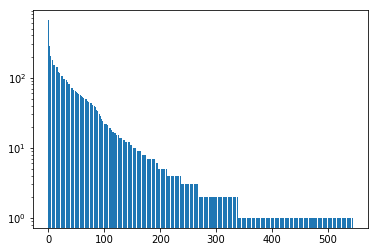

In [6]:
counts = np.histogram(brand_map, bins=range(0,max(brand_map)+1, 1))
counts = sorted(zip(*counts), reverse=True)
counts = [ (n,l) for n,l in counts if n>0]

for N in [200, 100, 50, 10]:
    print('{} brands with more than {} truth logos'.format(len([ (n,l) for n,l in counts if n>N]), N))
plt.bar(range(len(counts)), list(zip(*counts))[0])
plt.yscale('log');#plt.xscale('log')


## in-set similarity

For logos that are already in the dataset, how good is the cosine similarity with a test input to classify?

Given that we already have the true labels, we should separately check CS with the same class and different class. For example, testing Wells Fargo, we will check how good we are doing with respect to the true wells fargo images, and with respect to all other logos. This will allow us to look at TP/FP/TN/FN and metrics such as precision and recall

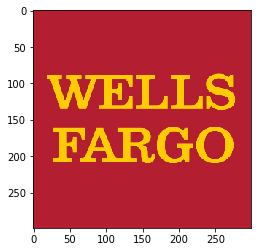

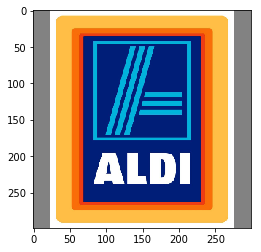

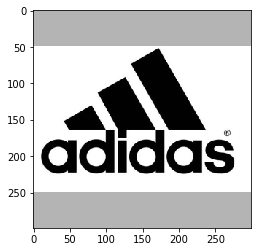

In [9]:
img_data = []
paths = ['test_wellsfargo.png', 'test_aldi.jpg', 'test_adidas1.png']
full_paths = [ os.path.join('../data/test/test_brands/', path) for path in paths]
for img_path in full_paths:
    img = utils.pad_image(cv2.imread(img_path)[:,:,::-1], input_shape)
    img_data.append(img)
    
    plt.imshow(img/255)
    plt.show()

In [12]:
feat_input = utils.features_from_image(np.array(img_data), model, my_preprocess)

cs = cosine_similarity(X = feat_input, Y = features)

Histograms of three different input brands imported above

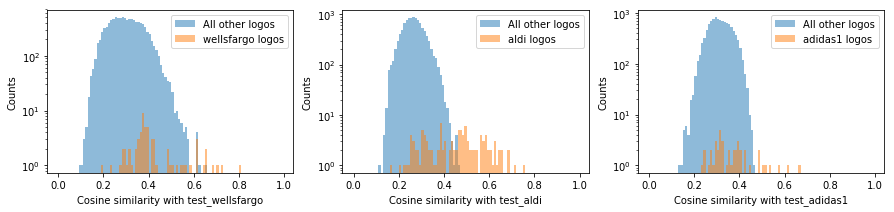

In [13]:
fig, axes = plt.subplots(1,3,figsize=(15,3))
for i_input in range(len(cs)):
    brand = ['wellsfargo', 'aldi', 'adidas1'][i_input]
    same_idx = [ i for i,b in enumerate(brand_map) if b == all_classes.index(brand)]
    diff_idx = [ i for i,b in enumerate(brand_map) if b != all_classes.index(brand)]
    

    axes[i_input].hist(cs[i_input][diff_idx], bins=np.arange(0,1,0.01),alpha=0.5, label='All other logos')
    axes[i_input].hist(cs[i_input][same_idx], bins=np.arange(0,1,0.01),alpha=0.5, label='{} logos'.format(brand))
    axes[i_input].set(yscale='log', xlabel='Cosine similarity with test_{}'.format(brand), ylabel='Counts')
    axes[i_input].legend()

We can draw a precision-recall curve by taking the histograms above and using the cosine similarity as our discriminator. This will be more or less good depending on the brand (as seen degree of separation in histograms)

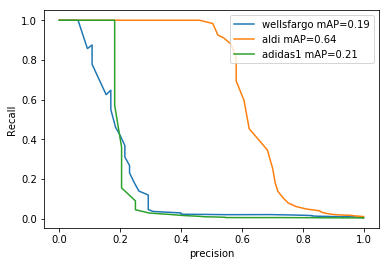

In [14]:
for i_input in range(len(cs)):
    brand = ['wellsfargo', 'aldi', 'adidas1'][i_input]
    same_idx = [ i for i,b in enumerate(brand_map) if b == all_classes.index(brand)]
    diff_idx = [ i for i,b in enumerate(brand_map) if b != all_classes.index(brand)]

    tp, fp, tn, fn = [],[],[],[]
    for thr in reversed(np.arange(0,1,0.01)):
        tp.append(len([c for c in cs[i_input][same_idx] if c >= thr ]))
        fp.append(len([c for c in cs[i_input][diff_idx] if c >= thr ]))
        fn.append(len([c for c in cs[i_input][same_idx] if c < thr ]))
        tn.append(len([c for c in cs[i_input][diff_idx] if c < thr ]))
    tp, fp, tn, fn = map(np.array, [tp, fp, tn, fn])
    rec, prec = (tp+0.01)/(tp+fn+0.01), (tp+0.01)/(tp+fp+0.01)
    plt.plot(rec, prec, label = '{} mAP={:.2f}'.format(brand, np.trapz(prec, rec)))
    plt.gca().set(ylabel='Recall', xlabel='precision')
    plt.legend();

We see that Aldi is doing great, while the other two examples are very poor. Let us look at the logos themselves as a function of cosine similarity to try and understand what is going on

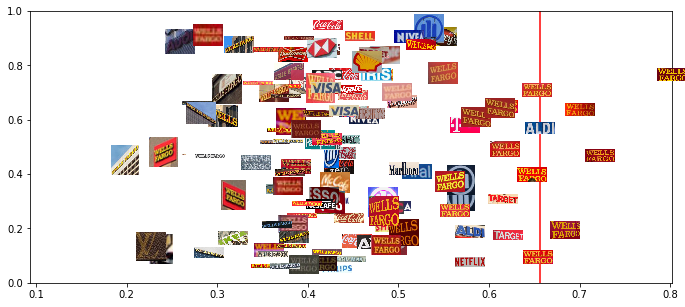

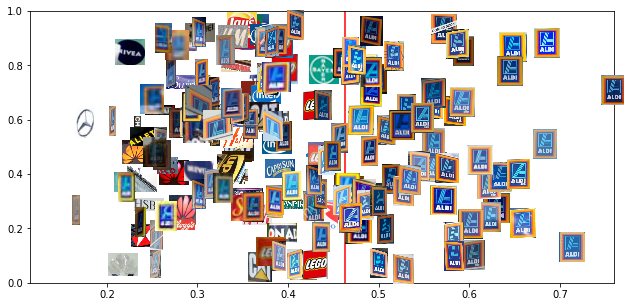

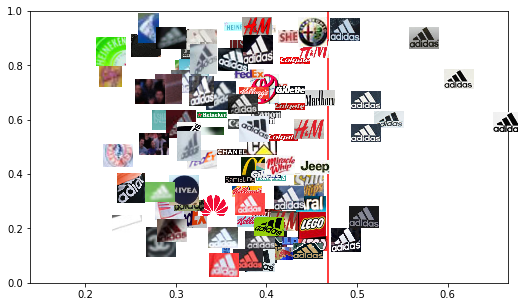

In [86]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

for i_input in range(len(cs)):
    brand = ['wellsfargo', 'aldi', 'adidas1'][i_input]
    same_idx = [ i for i,b in enumerate(brand_map) if b == all_classes.index(brand)]
    diff_idx = [ i for i,b in enumerate(brand_map) if b != all_classes.index(brand)]

    artists=[]
    diff_idx_sort = list(np.argsort(cs[i_input][diff_idx]))
    diff_sample = diff_idx_sort[-10:] + diff_idx_sort[-200::10] + diff_idx_sort[-800:-200:20] 
    for idx in reversed(same_idx+diff_sample):

        img = all_logos[idx]
        
        # reshape all logos to same size
        ih, iw = img.shape[:2]
        h, w = input_shape[:2]
        scale = min(w/iw, h/ih)
        nw, nh = int(iw * scale), int(ih * scale)
        img_data = cv2.resize(img, (nw, nh))

        left = cs[i_input][idx]
        bottom = 0.05 + np.random.rand()*0.9

        ab = AnnotationBbox(OffsetImage((img_data), zoom=0.1), (left, bottom), frameon=False)
        artists.append(plt.gca().add_artist(ab))

    plt.gca().set(xlim=(min(cs[i_input]),max(cs[i_input])), ylim=(0,1), aspect=0.3)
    plt.axvline(np.max(cs[i_input][diff_idx]), c='r');
    plt.gcf().set_size_inches(12,5)
    plt.show()

For Wells Fargo it's easier to see what's going on: many of the logos marked as wells fargo have a different style than the input (for example, written in one-line instead of two). On the other hand, many look the same (maybe with the logo slightly cut off, or with the letters "poppin out" of a sign seen diagonally): those could be addressed by training the feature extractor with more data augmentation (blurrring, shearing, rotating...).

## out-of-set similarity

### batman

YOLO on test11.jpg:
```
logo 0.02 (608, 438) (808, 471)
logo 0.75 (1118, 545) (1183, 630)
logo 0.96 (332, 467) (452, 545)
```

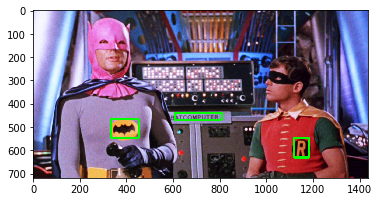

In [15]:
img_yo = cv2.imread('../data/test/sample_in/test11.jpg')[...,::-1]
img = img_yo.copy()
bboxes = [(608, 438, 808, 471), (1118, 545, 1183, 630), (332, 467, 452, 545)]
for bb in bboxes:    
    plt.imshow(cv2.rectangle(img, bb[:2], bb[2:], (0,255,0), 8)/255)

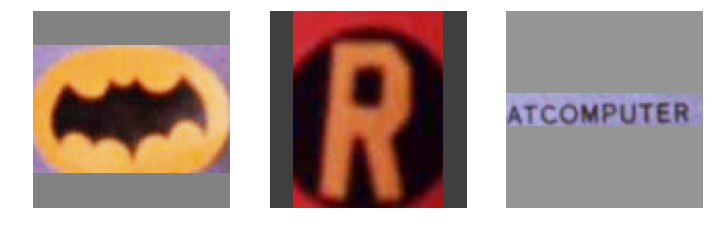

In [16]:
fig, axes = plt.subplots(1,len(bboxes),figsize=(12,5))
candidates = []
for iax, (xmin, ymin, xmax, ymax) in enumerate(bboxes[::-1]):
    candidate = utils.pad_image(img_yo[ymin:ymax, xmin:xmax], input_shape)
    axes[iax].imshow(candidate/255)
    axes[iax].set_axis_off()
    candidates.append(candidate)
candidates = np.array(candidates)

features_cand = utils.features_from_image(candidates, model, my_preprocess)

We will test these logos against the batman logo, the robin logo, and the in-set logos we had above

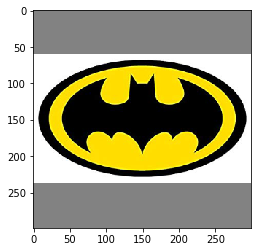

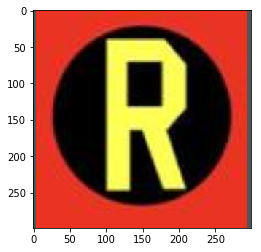

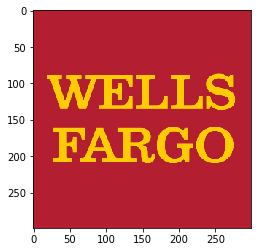

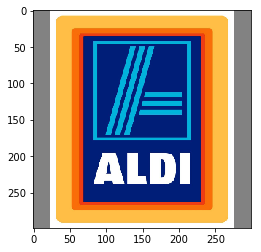

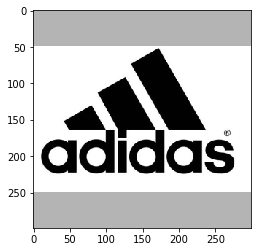

In [17]:
img_data = []
paths = ['test_batman.jpg','test_robin.png','test_wellsfargo.png', 'test_aldi.jpg', 'test_adidas1.png']
full_paths = [ os.path.join('../data/test/test_brands/', path) for path in paths]
for img_path in full_paths:
    img = utils.pad_image(cv2.imread(img_path)[:,:,::-1], input_shape)
    plt.imshow(img/255)
    plt.show()

    img_data.append(img)


In [18]:
feat_input = utils.features_from_image(np.array(img_data), model, my_preprocess)

cc = cosine_similarity(X = feat_input, Y = features_cand)

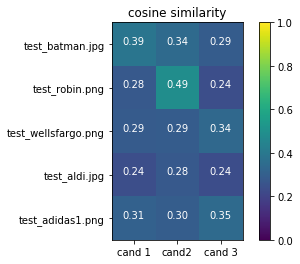

In [19]:
im = plt.imshow(cc, vmax=1, vmin=0);
[plt.text(j,i,'{:.2f}'.format(cc[i,j]), color='w', ha='center') for i in range(len(cc)) for j in range(len(cc[0]))]
plt.colorbar(im);
plt.gca().set(xticks=range(len(cc[0])),xticklabels=['cand 1','cand2','cand 3'], 
              yticks=range(len(cc)),yticklabels=paths, title='cosine similarity');

In [20]:
cs1 = cosine_similarity(X = feat_input, Y = features)

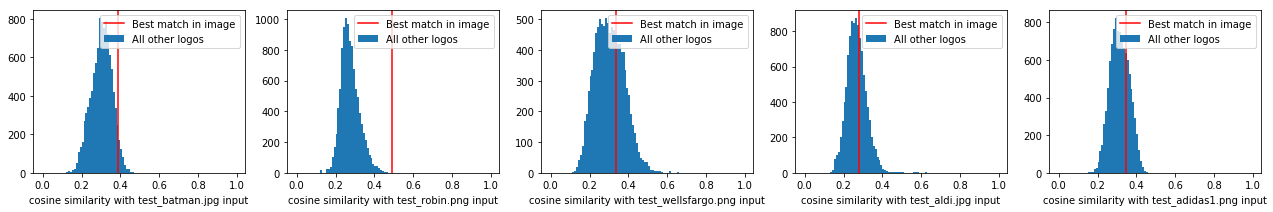

In [21]:
fig, axes = plt.subplots(1, len(cs1), figsize=(2+4*len(cs1),3))
for iax, ax in enumerate(axes):
    ax.hist(cs1[iax], bins=np.arange(0,1,0.01), label='All other logos');
    ax.axvline(np.max(cc[iax]), c='r', label='Best match in image');
    ax.set(xlabel='cosine similarity with {} input'.format(paths[iax]))
    ax.legend()

We can see that for the two logos that correctly match (Batman, Robin), the best match is on the edge of the cosine similarity distribution: this makes sense, as the recognized logos are more similar to the correct input logos than most other logos in the Logos In The Wild dataset.

For the three remaining input logos who are not in the picture, the best similarity found in the image is typical of the dataset (a randomly chosen logo is a likely as the best match found)

### lexus

YOLO on test9.jpg:
```
logo 0.34 (567, 458) (596, 467)
logo 0.90 (87, 243) (116, 271)
```

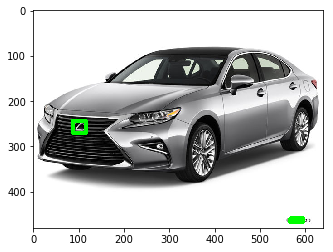

In [22]:
img_yo = cv2.imread('../data/test/sample_in/test9.jpg')[...,::-1]
img = img_yo.copy()
bboxes = [(567, 458, 596, 467), (87, 243, 116, 271)]
for bb in bboxes:    
    plt.imshow(cv2.rectangle(img, bb[:2], bb[2:], (0,255,0), 8)/255)

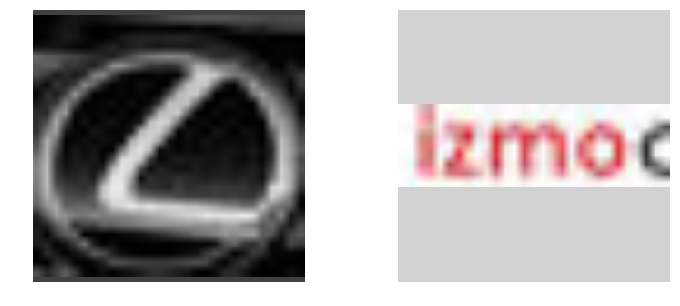

In [23]:
fig, axes = plt.subplots(1,len(bboxes),figsize=(12,5))
candidates = []
for iax, (xmin, ymin, xmax, ymax) in enumerate(bboxes[::-1]):
    candidate = utils.pad_image(img_yo[ymin:ymax, xmin:xmax], input_shape)
    axes[iax].imshow(candidate/255)
    axes[iax].set_axis_off()
    candidates.append(candidate)
candidates = np.array(candidates)

features_cand = utils.features_from_image(candidates, model, my_preprocess)

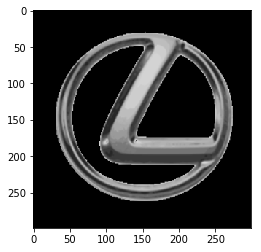

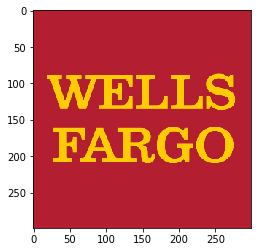

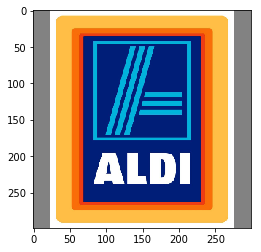

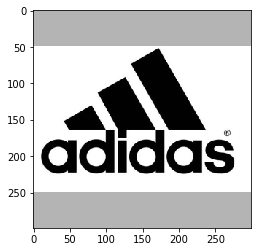

In [24]:
img_data = []
paths = ['test_lexus.png','test_wellsfargo.png', 'test_aldi.jpg', 'test_adidas1.png']
full_paths = [ os.path.join('../data/test/test_brands/', path) for path in paths]
for img_path in full_paths:
    img = utils.pad_image(cv2.imread(img_path)[:,:,::-1], input_shape)
    plt.imshow(img/255)
    plt.show()

    img_data.append(img)


In [25]:
feat_input = utils.features_from_image(np.array(img_data), model, my_preprocess)

cc = cosine_similarity(X = feat_input, Y = features_cand)

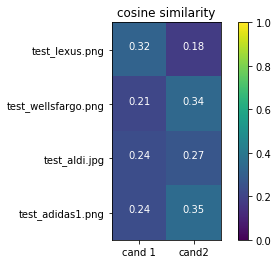

In [26]:
im = plt.imshow(cc, vmax=1, vmin=0);
[plt.text(j,i,'{:.2f}'.format(cc[i,j]), color='w', ha='center') for i in range(len(cc)) for j in range(len(cc[0]))]
plt.colorbar(im);
plt.gca().set(xticks=range(len(cc[0])),xticklabels=['cand 1','cand2','cand 3'], 
              yticks=range(len(cc)),yticklabels=paths, title='cosine similarity');

In [27]:
cs1 = cosine_similarity(X = feat_input, Y = features)

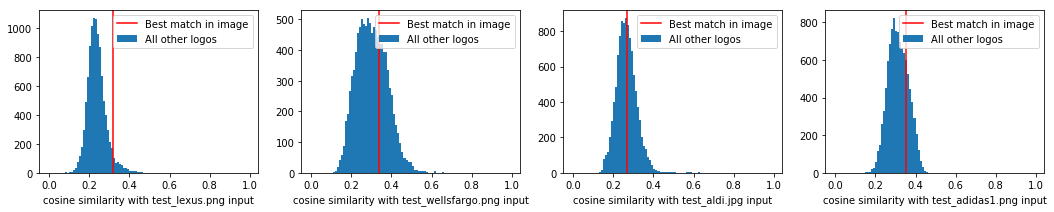

In [28]:
fig, axes = plt.subplots(1, len(cs1), figsize=(2+4*len(cs1),3))
for iax, ax in enumerate(axes):
    ax.hist(cs1[iax], bins=np.arange(0,1,0.01), label='All other logos');
    ax.axvline(np.max(cc[iax]), c='r', label='Best match in image');
    ax.set(xlabel='cosine similarity with {} input'.format(paths[iax]))
    ax.legend()

Again, we see that the correct Lexus logo sits at the end of the input distribution, while the other incorrect input candidates have cosine similarities in the bulk of the image.

We can also notice another thing: the cosine similarity of the second logo candidate is higher for other inputs than between Lexus and first logo. Absolute values of the cosine similarity are not good indicators, one should compare to **typical** values, which can be taken from the training data (the histograms above), and decide on a threshold

In [29]:
counts, bins = np.histogram(cs1[0], bins=np.arange(0,1,0.001))
cdf = np.cumsum(counts)/len(cs1[0])
print('95% level: {}'.format(bins[np.where(cdf < 0.95)][-1]))

95% level: 0.318


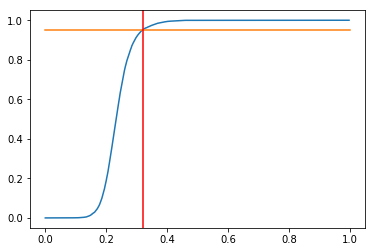

In [30]:
plt.plot(bins[:-1],cdf)
plt.plot((0,1),(0.95,0.95))
plt.axvline(np.max(cc[0]), c='r');

### duff
YOLO on test12.jpg:
```
logo 0.37 (258, 627) (470, 813)
logo 0.38 (299, 257) (404, 297)
logo 0.82 (513, 587) (695, 760)
logo 0.98 (67, 582) (241, 738)
```

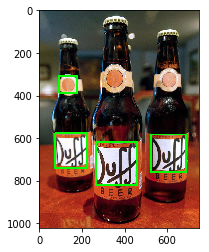

In [168]:
img_yo = cv2.imread('../data/test/sample_in/test12.jpg')[...,::-1]
img = img_yo.copy()
bboxes = [(94, 307, 178, 388), (265, 620, 461, 820), (525, 583, 688, 761),(74, 578, 223, 742)]
for bb in bboxes:    
    plt.imshow(cv2.rectangle(img, bb[:2], bb[2:], (0,255,0), 8)/255)

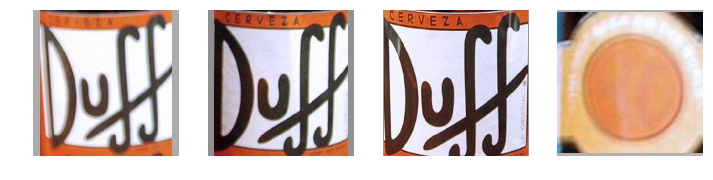

In [169]:
fig, axes = plt.subplots(1,len(bboxes),figsize=(12,5))
candidates = []
for iax, (xmin, ymin, xmax, ymax) in enumerate(bboxes[::-1]):
    candidate = utils.pad_image(img_yo[ymin:ymax, xmin:xmax], input_shape)
    axes[iax].imshow(candidate/255)
    axes[iax].set_axis_off()
    candidates.append(candidate)
candidates = np.array(candidates)

features_cand = utils.features_from_image(candidates, model, my_preprocess)

We will test these logos against the batman logo, the robin logo, and the in-set logos we had above

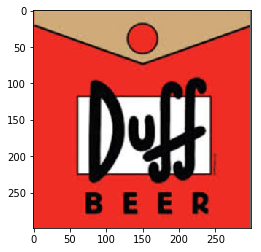

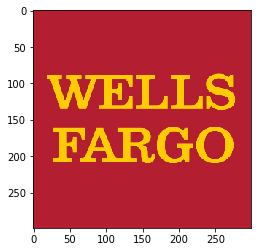

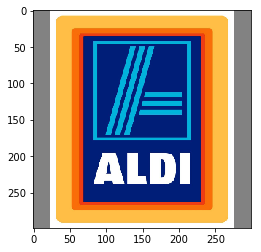

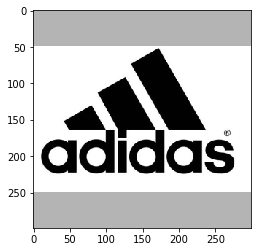

In [170]:
img_data = []
paths = ['test_duff.jpg','test_wellsfargo.png', 'test_aldi.jpg', 'test_adidas1.png']
full_paths = [ os.path.join('../data/test/test_brands/', path) for path in paths]
for img_path in full_paths:
    img = utils.pad_image(cv2.imread(img_path)[:,:,::-1], input_shape)
    plt.imshow(img/255)
    plt.show()

    img_data.append(img)


In [171]:
feat_input = utils.features_from_image(np.array(img_data), model, my_preprocess)

cc = cosine_similarity(X = feat_input, Y = features_cand)

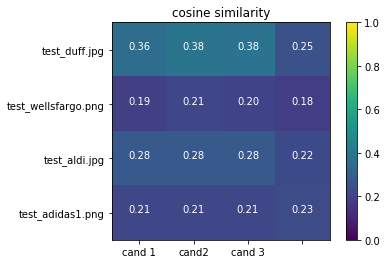

In [172]:
im = plt.imshow(cc, vmax=1, vmin=0);
[plt.text(j,i,'{:.2f}'.format(cc[i,j]), color='w', ha='center') for i in range(len(cc)) for j in range(len(cc[0]))]
plt.colorbar(im);
plt.gca().set(xticks=range(len(cc[0])),xticklabels=['cand 1','cand2','cand 3'], 
              yticks=range(len(cc)),yticklabels=paths, title='cosine similarity');

In [173]:
cs1 = cosine_similarity(X = feat_input, Y = features)

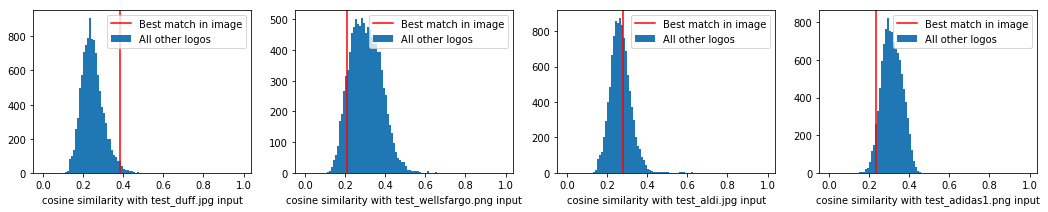

In [174]:
fig, axes = plt.subplots(1, len(cs1), figsize=(2+4*len(cs1),3))
for iax, ax in enumerate(axes):
    ax.hist(cs1[iax], bins=np.arange(0,1,0.01), label='All other logos');
    ax.axvline(np.max(cc[iax]), c='r', label='Best match in image');
    ax.set(xlabel='cosine similarity with {} input'.format(paths[iax]))
    ax.legend()

In [176]:
counts, bins = np.histogram(cs1[0], bins=np.arange(0,1,0.001))
cdf = np.cumsum(counts)/len(cs1[0])
print('95% level: {:.3f}'.format(bins[np.where(cdf < 0.95)][-1]))

95% level: 0.344
